<a href="https://colab.research.google.com/github/fedhere/MLTSA_FBianco/blob/master/CodeExamples/MCMCOutliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import pylab as pl
from scipy.optimize import curve_fit
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def line(x, slope, intercept):
  ''' function that generates a line
  x: exogenous variable
  slope: slope
  intergept: intercept'''

  return x * slope + intercept

def confidence_ellipse(x, y, sx, sy, cov,
                       ax, edgecolor='k', **kwargs):
    '''plots the confidence intervals as ellipses
    x: exogenous (vector)
    y: endogenous (vector)
    sx: error on the exogenous variable
    sy: error on the endogenous variable
    cov: covariance matrix
    ax: axis object
    edgecolor: color of the ellipses (optional)
    kwargs: other plot variables.
    '''
    
    n = len(x)
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

  
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    rots = np.arctan2(sy/y, sx/x)
    #print(rots)
    for i in range(n):
        ellipse = Ellipse((0, 0),
        width=sx[i],
        height=sy[i],
        edgecolor=edgecolor,
        facecolor='None',
        **kwargs)
        
        transf = transforms.Affine2D().rotate_deg(-cov[i][1,0]*180/np.pi)\
        .translate(x[i], y[i])
        #.rotate(rots[i])\
        
        ellipse.set_transform(transf + ax.transData)
        ax.add_patch(ellipse)


In [0]:
# read in data
data = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW4/table1.dat", sep=" ")

data.head()

In [0]:
data.head()

,x,y,sy,sx,rxy
0,201,592,61,9,-0.84
1,244,401,25,4,0.31
2,47,583,38,11,0.64
3,287,402,15,7,-0.27
4,203,495,21,5,-0.33


In [0]:
rdata = data[4:] 

In [0]:
nall = len(data)
n = nall - 5

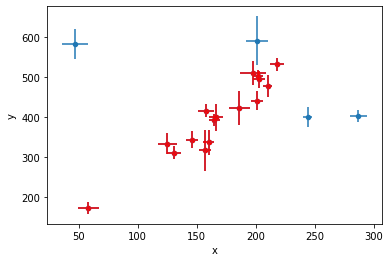

In [0]:
ax = data.plot(x='x', y="y", yerr="sy", xerr="sx", kind="scatter");
data[4:].plot(x='x', y="y", yerr="sy", xerr="sx", kind="scatter", ax=ax, color='r');

# numpy implementation with curvefit 

### on partial dataset

2  numpy implementation with curvefit¶


2.0.1  on partial dataset¶


# linear algebra solution

In [0]:
def makematrix(data, npar=2, verbose=False):
    '''
    turns data into matrix form
    
    data: dataframe including columns: x, y, sy'''
    if not ('sx' in  data.columns and\
    'x' in  data.columns and\
    'y' in  data.columns): 
        print ("data does not contain columns x, y, or sy")
        return np.nan, np.nan, np.nan
    
    
    if npar == 2:
        a = np.matrix(np.array([ones_like(data.x.values), data.x.values])).T
    elif npar == 3:
        a = np.matrix(np.array([ones_like(data.x.values), data.x.values, 
                                data.x.values* data.x.values])).T
    else: 
        print("wrong number of parameters {}".format(npar) + 
                "only linear npar=2) and quadratic (npar=3) fits enabled")
        return np.nan, np.nan, np.nan 
    Y = np.matrix(np.array([data.y.values])).T
    c = np.matrix(np.diag(data.sy.values**2))
    if verbose:
        #print(Y, a, c)
        print(Y.shape, a.shape, c.shape)
    return a, Y, c

### matrix solution line fit to partial dataset
3.1  1. partial set linear fit


In [0]:
a, Y, c = makematrix(rdata)
# A: transformation function: Ax=y
# y: target variable
# c: uncertainties vector
# (A^T c^-1 A A^T c^-1 Y)
bm = np.linalg.inv(a.T.dot(np.linalg.inv(c)).dot(a)).dot(
    a.T.dot(np.linalg.inv(c)).dot(Y))
bbmm = np.array(bm).T[0][::-1]
print("coefficients: slope {:.2f} intercept {:.1f}".format(*bbmm))

coefficients: slope 2.24 intercept 34.0


In [0]:
# fit with LA
yhat = a.dot(bm)

In [0]:
#residuals & error
yres = yhat - Y
s = yres.T.dot(yres) / (n - len(bm[1]))
# the number of parameters is the dimension of bm, 
# normalize by number of degrees of freedom of model: data points - number of parameters
print("normalized error from residuals", float(s))

normalized error from residuals 1034.4865754677917


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


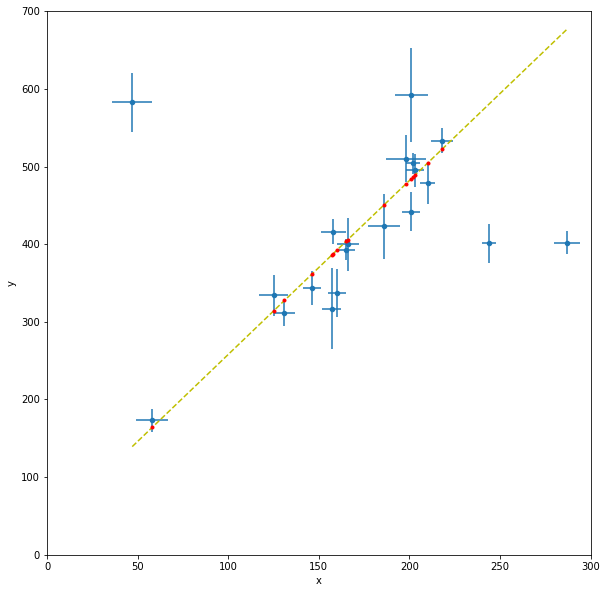

In [0]:
newx = [data.x.min(), data.x.max()]
ax = figure(figsize=(10,10), font).add_subplot();
ax = data.plot(x="x", y="y", yerr="sy", xerr="sx", kind="scatter", ax=ax);
plot(newx, 
     np.vstack(np.array([ones_like(newx), newx])).T.dot(bm), 
     'y--', label='fit: m=%5.3f, b=%5.3f' % tuple(
              (bm[0][0], bm[1][0])));
#LA
plot(rdata.x, np.array(yhat).flatten(), 'r.')
xlim(0,300)
ylim(0,700)
axes().set_aspect(np.diff(xlim()) / np.diff(ylim()));

### uncertainty
## 2. matrix solution line fit to full dataset

In [44]:
a2, Y2, c2 = makematrix(data)
# A^-T c^-1 A A^-T c^-1 y^-T
bmfull = np.linalg.inv(a2.T.dot(np.linalg.inv(c2)).dot(a2)).dot(
    a2.T.dot(np.linalg.inv(c2)).dot(np.matrix(data.y.values).T))
bmfull

matrix([[213.27349198],
        [  1.07674752]])

In [45]:
yhat2 = a2.dot(bmfull)
yres2 = yhat2 - Y2
s2 = yres2.T.dot(yres2) / (nall - 2)
s2

matrix([[10817.4625565]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


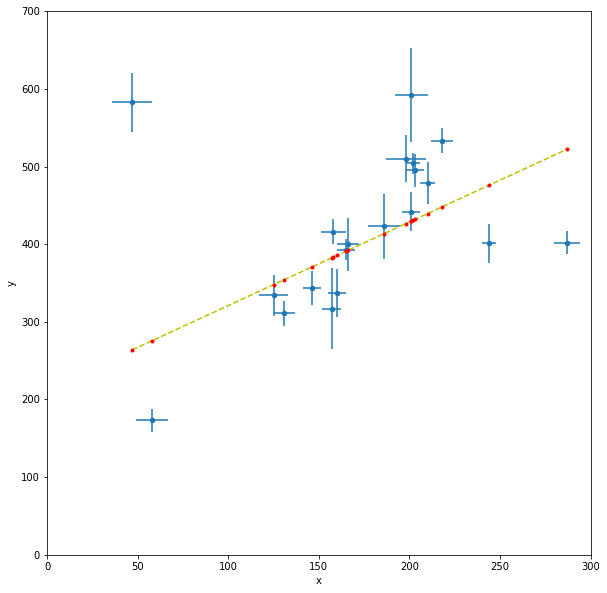

In [46]:
ax = figure(figsize=(10,10)).add_subplot();
ax = data.plot(x="x", y="y", yerr="sy", xerr="sx", kind="scatter", ax=ax);
plot(newx, 
    np.vstack(np.array([ones_like(newx), newx])).T.dot(bmfull),
     'y--',
          label='fit: m=%5.3f, b=%5.3f' % tuple((bmfull[0][0], bmfull[1][0])));
plot(data.x, np.array(a2.dot(bmfull)).flatten(), 'r.')
xlim(0,300)
ylim(0,700)
axes().set_aspect(np.diff(xlim()) / np.diff(ylim()));


## 5. MCMC

In [49]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11642 sha256=10c861c760fc065582df085de0fe562388f16dbb157624590cf343ed5d863ebd
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [0]:
import emcee
import corner
import scipy.optimize as op
from corner import hist2d

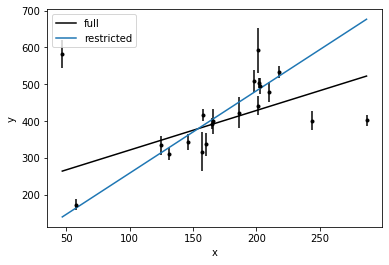

In [51]:
xx = np.arange(data.x.min(), data.x.max(), 0.1)
pl.errorbar(data.x, data.y, data.sy, fmt='.',  color='k')
pl.plot(xx, line(xx, bmfull[1,0], bmfull[0,0]), 'k-', label="full")
pl.plot(xx, line(xx, bm[1,0], bm[0,0]), '-', label="restricted")
pl.xlabel("x")
pl.ylabel("y")
pl.legend();mb

In [0]:
#define a log likelihood that includes 
# - parameters slope and intercept (m, b), 
def lnlike(theta, x, y, yerr):
    '''log likelihood
    theta: 5 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    '''
    
    m, b = theta
    #line fit model
    model = m * x + b
    #variance of data
    sig2 = yerr**2
    
    #normalization: this is importnat because we have 2 linearly combined pieces of model
    den = 2 * np.pi * sig2
    
    #this is the probability that the point comes from the line
    a = (1) / np.sqrt(den) *\
        exp(-(y-model)**2 /  2.0 / sig2)   
    return  np.sum(np.log(a))
    
def lnprior(theta):
    '''
    logprior on the parameters theta
    theta: 5 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                Pb probability that a point is an outlier,
                                V the variance of the process that generates outliers
    '''
    m, b = theta
    if -200 < b < 500 and 0 < m < 10.0 :
        #Pb is a probability so it is bound to 0-1
        return 0.0
    
    return -np.inf

def lnprob(theta, x, y, yerr):
    ''' log likelihood * log prior: the posterior
    '''
    lp = lnprior(theta)
    
    if not np.isfinite(lp) :
        return -np.inf
    lnl = lnlike(theta, x, y, yerr)
    if  np.isnan(lnl):
        return -np.inf
    return lp + lnl 

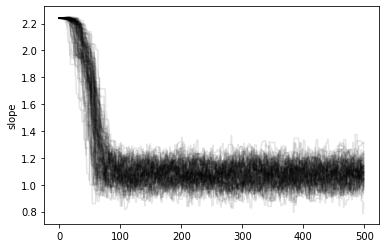

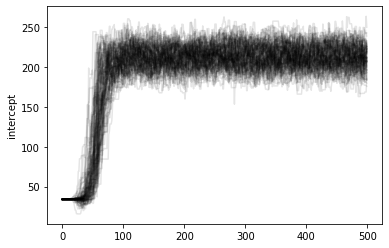

In [59]:
ndim, nwalkers = 2, 100 # number of variables optimized over, number of walkers per variable
init = np.hstack([bm[1,0], bm[0,0]]) # initialize the variable at a single point with some noise
pos = [init + 
       init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] #  
sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprob, 
                                args=(data.x, data.y,
                                     data.sy))
sampler.run_mcmc(pos, 500);
labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
               "Pb probability that a point is an outlier",
                 "V" ]
for i in range(ndim):
    pl.figure()
    for j in range(100): 
        pl.plot(sampler.chain[j,:,i], 'k', alpha=0.1)
    pl.ylabel(labels[i])
        
        
burnout = 150
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))


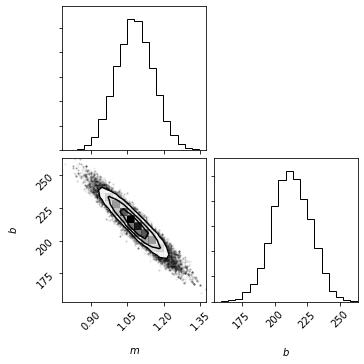

In [60]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Y", r"$P_b$", "V"],
                        truths=init)
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))

# MCMC with a noise generating process

In [0]:
#define a log likelihood that includes 
# - parameters slope and intercept (m, b), 
# - the probability that the point is an outlier Pb 
# - and a distribution fo the outliers, parameters (Yb, Vb), the mean and variance of the distribution of outliers

def lnlike(theta, x, y, yerr):
    '''log likelihood
    theta: 5 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    '''
    
    m, b, Yb, Pb, V = theta
    #line fit model
    model = m * x + b
    #variance of data
    sig2 = yerr**2
    
    #normalization: this is importnat because we have 2 linearly combined pieces of model
    den = 2 * np.pi * sig2
    
    #this is the probability that the point comes from the line
    a = (1 - Pb) / np.sqrt(den) *\
        exp(-(y-model)**2 /  2.0 / sig2)  
    #this is the probability that it does not
    b = Pb / np.sqrt(den + 2*np.pi*V) *\
        exp (-(y - Yb)**2 / 2 / (V + sig2))
    return  np.sum(np.log(a + b))

In [0]:
def lnprior(theta):
    '''
    logprior on the parameters theta
    theta: 5 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                Pb probability that a point is an outlier,
                                V the variance of the process that generates outliers
    '''
    m, b, Yb, Pb, V = theta
    if -200 < b < 500 and 0 < m < 10.0 :
        #Pb is a probability so it is bound to 0-1
        if Pb < 0 or Pb > 1:
            return -np.inf
        # set some constraints on the mean of the process that creates the outliers
        if  Yb > ymean + 150 or Yb < ymean - 150:
            return -np.inf

        if V < 0:
            return -np.inf
        #print("3")
        return 0.0
    
    return -np.inf

def lnprob(theta, x, y, yerr):
    ''' log likelihood * log prior: the posterior
    '''
    lp = lnprior(theta)
    
    if not np.isfinite(lp) :
        return -np.inf
    lnl = lnlike(theta, x, y, yerr)
    if  np.isnan(lnl):
        return -np.inf
    return lp + lnl 

In [0]:
ymean = data.y.mean()
#initialize from the restricted problem LA solution 


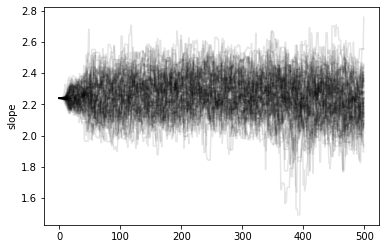

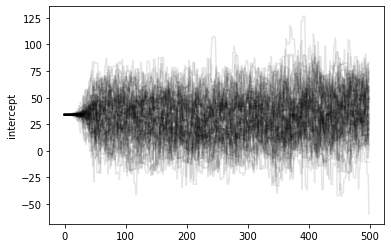

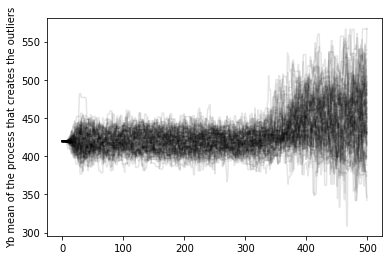

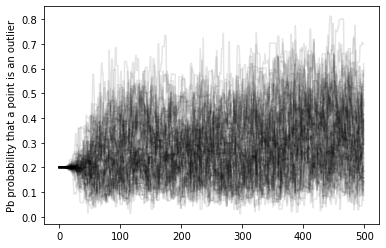

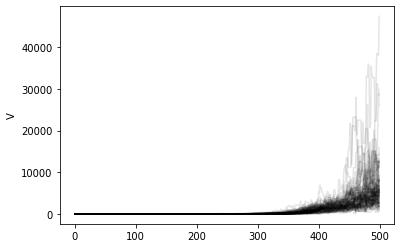

In [55]:
ndim, nwalkers = 5, 100 # number of variables optimized over, number of walkers per variable
init = np.hstack([bm[1,0], bm[0,0], ymean, 
                  0.2, 0.1]) # initialize the variable at a single point with some noise
pos = [init + 
       init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] #  
sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprob, 
                                args=(data.x, data.y,
                                     data.sy))
sampler.run_mcmc(pos, 500);
labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
               "Pb probability that a point is an outlier",
                 "V" ]
for i in range(ndim):
    pl.figure()
    for j in range(100): 
        pl.plot(sampler.chain[j,:,i], 'k', alpha=0.1)
    pl.ylabel(labels[i])
        
        
burnout = 150
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

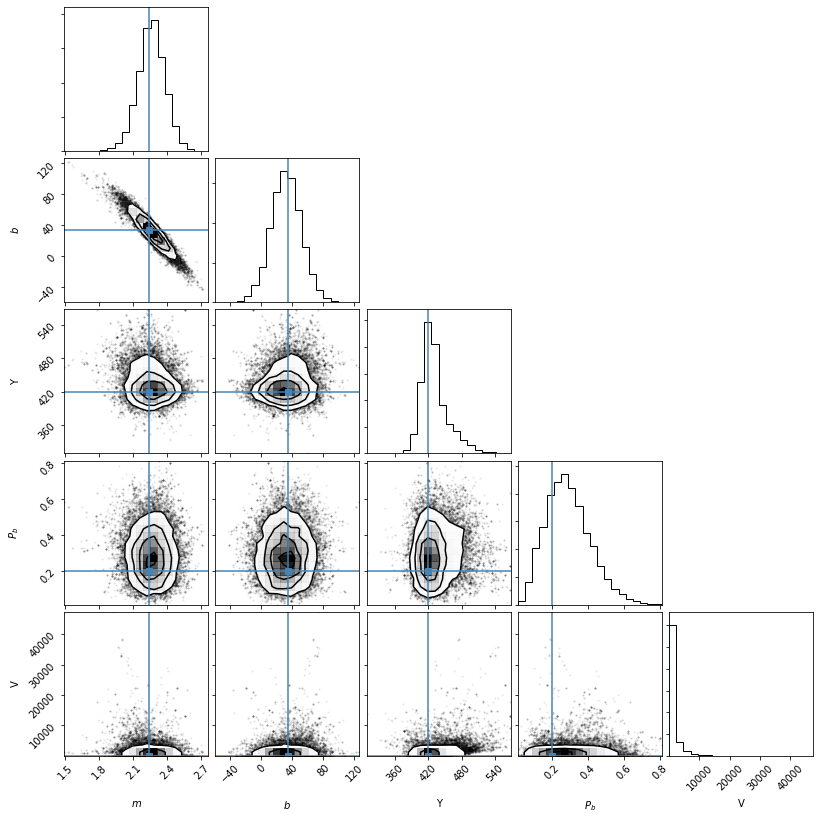

In [56]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Y", r"$P_b$", "V"],
                        truths=init)
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))